## Apache Spark machine library (MLlib)

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MyApp").getOrCreate()

## Load sample data

In [5]:
# Use the Spark CSV datasource with options specifying:
# - First line of file is a header
# - Automatically infer the schema of the data
data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("data_geo_local.csv")
# databricks
#data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/databricks-datasets/samples/population-vs-price/data_geo.csv")

data.cache() # Cache data for faster reuse

DataFrame[2014 rank: int, City: string, State: string, State Code: string, 2014 Population estimate: int, 2015 median sales price: double]

View the data in tabular form

In [9]:
# databricks, this nicely shows the first rows
#display(data)
data.show(10)

+---------+-------------+-------+----------+------------------------+-----------------------+
|2014 rank|         City|  State|State Code|2014 Population estimate|2015 median sales price|
+---------+-------------+-------+----------+------------------------+-----------------------+
|      101|   Birmingham|Alabama|        AL|                  212247|                  162.9|
|      125|   Huntsville|Alabama|        AL|                  188226|                  157.7|
|      122|       Mobile|Alabama|        AL|                  194675|                  122.5|
|      114|   Montgomery|Alabama|        AL|                  200481|                  129.0|
|       64|Anchorage[19]| Alaska|        AK|                  301010|                   NULL|
|       78|     Chandler|Arizona|        AZ|                  254276|                   NULL|
|       86|  Gilbert[20]|Arizona|        AZ|                  239277|                   NULL|
|       88|     Glendale|Arizona|        AZ|                

## Prepare and visualize data

In this linear regression example, the label is the 2015 median sales price and the feature is the 2014 Population Estimate. That is, you use the feature (population) to predict the label (sales price).

In [10]:
from pyspark.sql.functions import col

# First drop rows with missing values
data = data.dropna() # drop rows with missing values
# rename the feature and label columns, replacing spaces with _
exprs = [col(column).alias(column.replace(' ', '_')) for column in data.columns]

To simplify the creation of features, register a UDF to convert the feature (`2014_Population_estimate`) column vector to a `VectorUDT` type and apply it to the column.

#### UDF = User-Defined Function

Spark ships with a large catalogue of SQL functions, but real-world logic (domain-specific parsing, proprietary scoring rules, complex geo math, etc.) often isn’t covered. A UDF lets you drop into *your* language (Python, Scala, Java, R) to express that logic.

Use a UDF when:  

• No built-in expression can do the job.  
• The logic is complex but not latency-critical.  

**Key takeaways**

• A UDF extends Spark’s function library with custom code.  
• Easy to write; potentially expensive to run (serialization + no optimization).  
• Prefer built-ins; fall back to vectorized (Pandas) UDFs or native Scala UDFs when custom logic is unavoidable.

In [11]:
from pyspark.ml.linalg import Vectors, VectorUDT

spark.udf.register("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())
tdata = data.select(*exprs).selectExpr("oneElementVec(2014_Population_estimate) as features", "2015_median_sales_price as label")

In [13]:
# databricks
#display(tdata)
tdata.show(10)

+-----------+-----+
|   features|label|
+-----------+-----+
| [212247.0]|162.9|
| [188226.0]|157.7|
| [194675.0]|122.5|
| [200481.0]|129.0|
|[1537058.0]|206.1|
| [527972.0]|178.1|
| [197706.0]|131.8|
| [346997.0]|685.7|
|[3928864.0]|434.7|
| [319504.0]|281.0|
+-----------+-----+
only showing top 10 rows



## Perform linear regression

We run two different linear regression models using different regularization parameters to determine how well either of these two models predict the *sales price* (label) based on the *population* (feature).

### Build the model

In [14]:
# Import LinearRegression class
from pyspark.ml.regression import LinearRegression

# Define LinearRegression algorithm
lr = LinearRegression()

In [16]:
# Fit 2 models, using different regularization parameters
modelA = lr.fit(tdata, {lr.regParam:0.0})
modelB = lr.fit(tdata, {lr.regParam:100.0})

Using the model, you can also make predictions by using the transform() function, which adds a new column of predictions. For example, the code below takes the first model (modelA) and shows you both the label (original sales price) and prediction (predicted sales price) based on the features (population).

In [19]:
# Make predictions
predictionsA = modelA.transform(tdata)
predictionsA.show(10)

+-----------+-----+------------------+
|   features|label|        prediction|
+-----------+-----+------------------+
| [212247.0]|162.9| 199.3167659584664|
| [188226.0]|157.7|198.40882267887193|
| [194675.0]|122.5|198.65258131548592|
| [200481.0]|129.0|198.87203590444247|
|[1537058.0]|206.1|249.39183544694856|
| [527972.0]|178.1|211.25050693302884|
| [197706.0]|131.8| 198.7671467407576|
| [346997.0]|685.7| 204.4100325554172|
|[3928864.0]|434.7|339.79707185649573|
| [319504.0]|281.0|203.37085497805194|
+-----------+-----+------------------+
only showing top 10 rows



### Evaluate

To evaluate the regression analysis, calculate the root mean square error using the RegressionEvaluator. Here is the Python code for evaluating the two models and their output.

In [22]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse")
RMSE = evaluator.evaluate(predictionsA)
print("ModelA: Root Mean Squared Error = " + str(RMSE))

predictionsB = modelB.transform(tdata)
RMSE = evaluator.evaluate(predictionsB)
print("ModelB: Root Mean Squared Error = " + str(RMSE))

ModelA: Root Mean Squared Error = 128.60202684284758
ModelB: Root Mean Squared Error = 129.49630019270606


### Visualize

In [25]:
# Import numpy, pandas, and ggplot
import numpy as np
from pandas import *
import matplotlib.pyplot as plt
#from ggplot import *

In [29]:
# Create Python DataFrame
pop = tdata.rdd.map(lambda p: (p.features[0])).collect()
price = tdata.rdd.map(lambda p: (p.label)).collect()
predA = predictionsA.select("prediction").rdd.map(lambda r: r[0]).collect()
predB = predictionsB.select("prediction").rdd.map(lambda r: r[0]).collect()

# Create a Pandas DataFrame
df = DataFrame({'pop':pop,'price':price,'predA':predA, 'predB':predB})

If `ggplot` is installed:

```python
# Create scatter plot and two regression models (scaling exponential) using ggplot
p = ggplot(pydf, aes('pop','price')) +
  geom_point(color='blue') +
  geom_line(pydf, aes('pop','predA'), color='red') +
  geom_line(pydf, aes('pop','predB'), color='green') +
  scale_x_log10() + scale_y_log10()
display(p)
```

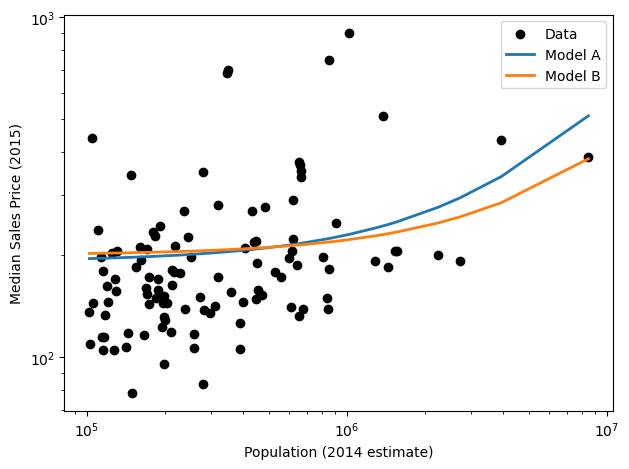

In [35]:
# sort by population to keep lines monotonic
pydf_sorted = pydf.sort_values('pop')

plt.scatter(pydf_sorted['pop'], pydf_sorted['price'], label='Data', color='k')
plt.plot(pydf_sorted['pop'], pydf_sorted['predA'], linewidth=2, label='Model A')
plt.plot(pydf_sorted['pop'], pydf_sorted['predB'], linewidth=2, label='Model B')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Population (2014 estimate)')
plt.ylabel('Median Sales Price (2015)')
plt.legend()
plt.tight_layout()
plt.show()